In [1]:
import pymc3 as pm
import pandas as pd
import matplotlib.pyplot as plt
from theano import tensor as T
import numpy as np

In [2]:
df = pd.read_csv("../../data/Italy/google_mobility_covariates_processed.csv")

In [3]:
df

,index,state,county,denominazione_regione,google_county,date,grocery/pharmacy,parks,residential,retail/recreation,transitstations,workplace
0,0,IT,Abruzzo,Abruzzo,Abruzzo,2020-02-16,8.323,48.917,-1.654,2.274,27.494,-0.990
1,1,IT,Abruzzo,Abruzzo,Abruzzo,2020-02-17,2.002,11.552,-0.581,-1.524,7.500,1.339
2,2,IT,Abruzzo,Abruzzo,Abruzzo,2020-02-18,1.665,22.410,-0.896,0.711,5.702,1.706
3,3,IT,Abruzzo,Abruzzo,Abruzzo,2020-02-19,-1.142,-12.165,-0.100,-3.886,0.867,1.184
4,4,IT,Abruzzo,Abruzzo,Abruzzo,2020-02-20,3.911,-2.945,-0.361,0.952,4.909,1.006
...,...,...,...,...,...,...,...,...,...,...,...,...
941,984,IT,Veneto,Veneto,Veneto,2020-03-25,-45.159,-85.382,34.701,-86.119,-84.242,-67.484
942,985,IT,Veneto,Veneto,Veneto,2020-03-26,-45.431,-87.074,37.575,-87.347,-86.215,-72.279
943,986,IT,Veneto,Veneto,Veneto,2020-03-27,-38.983,-85.685,39.184,-86.916,-86.188,-71.694
944,987,IT,Veneto,Veneto,Veneto,2020-03-28,-53.852,-91.030,29.456,-91.773,-87.497,-67.755


In [4]:
df_county = df[df["google_county"] == "Abruzzo"]

In [5]:
df_county.head()

,index,state,county,denominazione_regione,google_county,date,grocery/pharmacy,parks,residential,retail/recreation,transitstations,workplace
0,0,IT,Abruzzo,Abruzzo,Abruzzo,2020-02-16,8.323,48.917,-1.654,2.274,27.494,-0.990
1,1,IT,Abruzzo,Abruzzo,Abruzzo,2020-02-17,2.002,11.552,-0.581,-1.524,7.500,1.339
2,2,IT,Abruzzo,Abruzzo,Abruzzo,2020-02-18,1.665,22.410,-0.896,0.711,5.702,1.706
3,3,IT,Abruzzo,Abruzzo,Abruzzo,2020-02-19,-1.142,-12.165,-0.100,-3.886,0.867,1.184
4,4,IT,Abruzzo,Abruzzo,Abruzzo,2020-02-20,3.911,-2.945,-0.361,0.952,4.909,1.006


# Can loop over all the counties.

In [6]:
# set time t and data for changepoint
t = df_county.index.values
data = df_county.residential.values

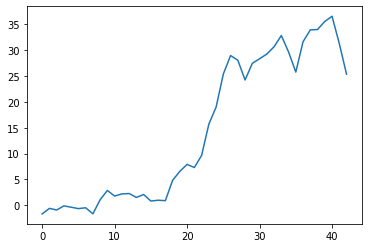

In [7]:
plt.plot(t, data)

In [9]:
with pm.Model() as model: # context management

    #define uniform priors. These priors can be changed so this is just an illustration
    mu1 = pm.Uniform("mu1",0,40)
    mu2 = pm.Uniform("mu2",10,40)
    mu3 = pm.Uniform("mu3",20,40)
    sigma = pm.Uniform("sigma",1.e-3,100)
    tau1 = pm.DiscreteUniform("tau1",t.min(),t.max())
    tau2 = pm.DiscreteUniform("tau2",tau1,t.max())

    #define stochastic variable mu
    _mu = T.switch(tau1>=t,mu1,mu2)
    mu = T.switch(tau2>=t,_mu,mu3)

    #define formula for log-likelihood
    logp = - T.log(sigma * T.sqrt(2.0 * np.pi)) \
           - T.sqr(data - mu) / (2.0 * sigma * sigma)
    
    def logp_func(data):
        return logp.sum()

    #find out log-likelihood of observed data
    L_obs = pm.DensityDist('L_obs', logp_func, observed=data)

    #start MCMC algorithm
    trace = pm.sample(4000, random_seed=123, progressbar=True)


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [sigma, mu3, mu2, mu1]
>CompoundStep
>>Metropolis: [tau2]
>>Metropolis: [tau1]
Sampling 4 chains, 0 divergences: 100%|██████████| 18000/18000 [00:13<00:00, 1377.27draws/s]
The acceptance probability does not match the target. It is 0.8832823638000171, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.635337057994451, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f516d220fd0>,
      dtype=object)

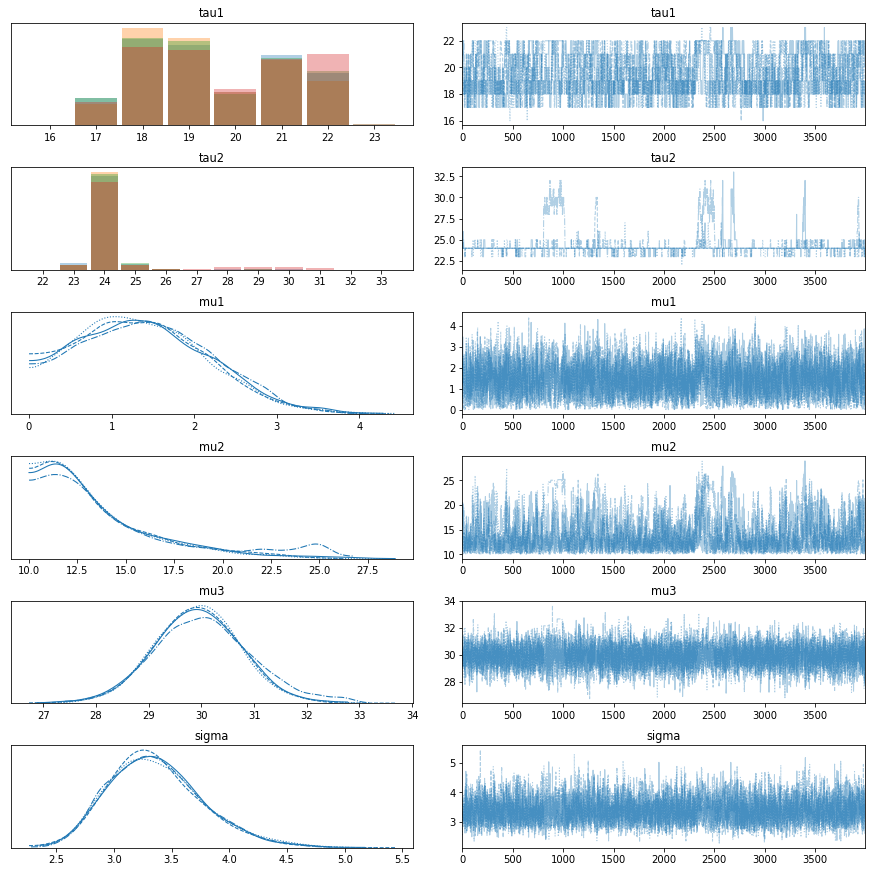

In [10]:
pm.traceplot(trace)

Text(0.5, 1.0, 'Abruzzo')

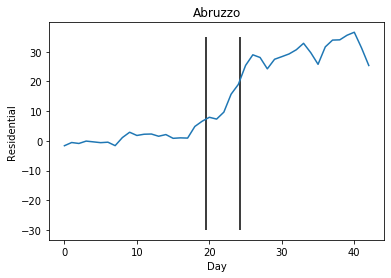

In [11]:
plt.plot(t, data)
plt.vlines([trace.get_values("tau1").mean(), trace.get_values("tau2").mean()], ymax=35, ymin=-30)
plt.ylabel("Residential")
plt.xlabel("Day")
plt.title("Abruzzo")